# D213 - Advanced Data Analytics
### NLM3 Task 1: Time Series Modeling
#### Advanced Data Analytics — D213
#### PRFA — NLM3
> André Davis
> StudentID: 010630641
> MSDA
>
> Competencies
> 4030.7.2 : Time Series Analysis
> The graduate applies time series models in generating forecasts. 

#### Table of Contents
<ul>
    <li><a href="#research-question">A1: Research Question</a></li>
    <li><a href="#objectives">A2: Objectives and Goals of Analysis</a></li>
    <li><a href="#assumptions">B: Assumptions of Time Series Model</a></li>
    <li><a href="#visualizations">C1: Time Series Visualization</a></li>
    <li><a href="#time-step-description">C2: Description of Time Step Formatting</a></li>
    <li><a href="#stationary-of-series">C3: Stationarity of Series</a></li>
    <li><a href="#data-preparation">C4: Data Preparation & Explanation</a></li>
    <li><a href="#copy-of-prepared-data">C5: Copy of Prepared Data Set</a></li>
    <li><a href="#annotated-findings-and-visualizations">D1: Annotated Findings & Visualizations</a></li>
    <li><a href="#arima-model-of-time-series-data">D2: ARIMA Model of Time Series Data</a></li>
    <li><a href="#forcast">D3: Forecast</a></li>
    <li><a href="#analysis">D4: Analysis Output & Calculations</a></li>
    <li><a href="#arima-code">D5: ARIMA Model Code</a></li>
    <li><a href="#results-of-analysis">E1: Results of Analysis</a></li> 
    <li><a href="#forcast-visualizations">E2: Visualization of Forecast</a></li> 
    <li><a href="#recommendations">E3: Recommended Action</a></li>
    <li><a href="#reporting">F: Reporting</a></li>
    <li><a href="#code-references">G: Code References</a></li>
    <li><a href="#source-references">H: Source References</a></li>    
</ul>

<a id="research-question"></a>
# A1: Research Question

The research question explored in this report is: "Is it possible to accurately and effectively forecast the daily revenues of [`WGU`](https://www.wgu.edu/) Hospital System in a manner that aligns closely with the actual observed daily revenues?"

<a id="objectives"></a>
# A2: Objectives and Goals of Analysis

The objective of this analysis is to accurately predict daily revenues for the [`WGU`](https://www.wgu.edu) Hospital System utilizing the available dataset. The analysis employs an 80-20 split of the dataset, using the initial 80% as a training set to forecast the remaining 20%, which serves as a test set. This approach allows for the use of observed values as a benchmark for comparison. An ARIMA time series model will be utilized to analyze the training set and project the values in the test set.

> ARIMA is a "model runs *d* rounds of differencing to make the time series more stationary, then it applies a regular ARMA Model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing."(Géron, 2022).

<a id="assumptions"></a>
# B: Assumptions of Time Series Model

>The submission accurately summarizes each of the assumptions of a time series model. The summary includes stationarity and autocorrelated data.

Assumptions of the ARMA Family of Models, including ARIMA include:

 1. Data must not include outliers and/or anomalies 
 2. The time series data should exhibit stationary, devoid of any trends or seasonal fluctuations.
 3. Datapoints in the past must be indicative of future datapoints in behavior.
 4. The data must reflect a single variable and be classified as uni-variate to be modelled.
 5. The data must be auto-correlated for ARIMA model to perform forecasting via Autoregressive Component 

Some observational notes about the [`WGU Medical Time Series Dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip) and the assumption point #3. Because this is a Performance Assessment for graduate school, the data presented for this activity is pretty limited. There are 730 rows and because this is a daily record, this equals 2 years of daily data. It may or may not be enough information to know if the past data indicates future behavior.

<a id="visualizations"></a>
# C1: Time Series Visualization

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

medical_daily_revenue = pd.read_csv('./medical_time_series.csv')
medical_daily_revenue.info()

print(f'\nTotal Records: [{len(medical_daily_revenue)}]')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB

Total Records: [731]


#### Visualization of the Medical Daily Revenue Dataset

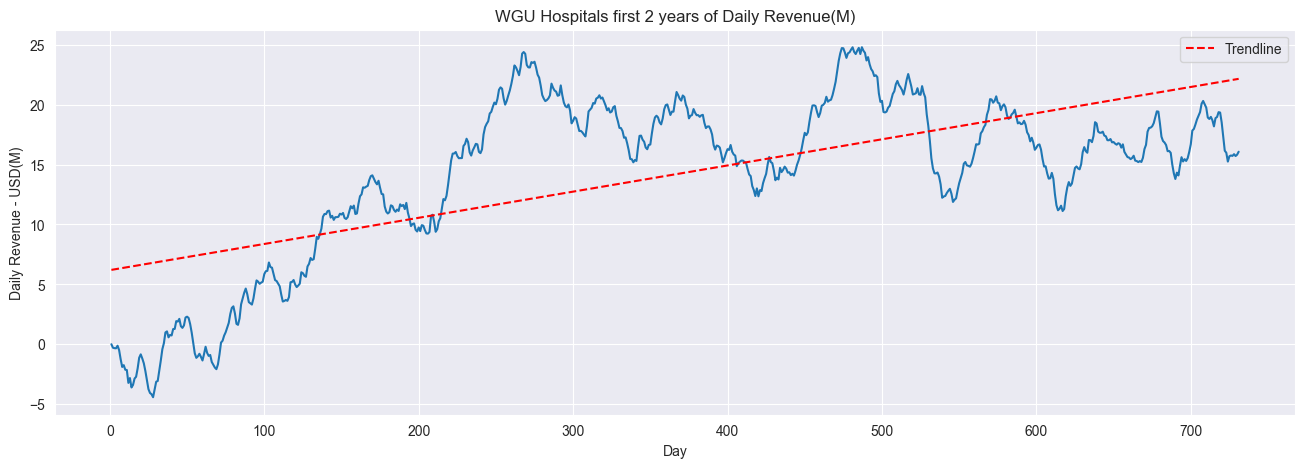

In [60]:
plt.figure(figsize=(16,5))
plt.xlabel('Day')
plt.ylabel('Daily Revenue - USD(M)')
plt.title('WGU Hospitals first 2 years of Daily Revenue(M)')

x_days = medical_daily_revenue['Day']
y_revenue = medical_daily_revenue['Revenue']
plt.plot(x_days, y_revenue)

#generate trend line
polynomial_coefficients = np.polyfit(x_days, y_revenue, 1)
polynomial_function = np.poly1d(polynomial_coefficients) 

plt.plot(x_days, polynomial_function(x_days), c='r', linestyle='--', label='Trendline')
plt.legend()

plt.show()

<a id="time-step-description"></a>
# C2: Description of Time Step Formatting

The format of the time series data is pretty straight forward. We have two variables(columns) called `Day` and `Revenue`. The data represents revenue in the millions per day for two years since the opening of the *WGU Hospital*. The data does not contain any missing revenue values or days as it's a complete data set starting at Day 1 and continuing through Day 731, which is two years worth of data. The fact the total data is 731 and not 730 could indicate that the 2 years spanned through a [leap year](https://en.wikipedia.org/wiki/Leap_year) in February.

<a id="stationary-of-series"></a>
# C3: Stationary of Series

To test whether or not the data is stationary or not we will back-up the visual check with the Augmented Dickery-Fuller (ADF) test.

> "Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series." (Prabhakaran, 2022)

In [61]:
'''
Augmented Dickey-Fuller Documentation: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

statsmodels.tsa.stattools.adfuller(
    x, 
    maxlag=None, 
    regression='c', 
    autolag='AIC', 
    store=False, 
    regresults=False
)
'''

adf, p_value, used_lag, nobs, critical_values, icbest = adfuller(y_revenue)

print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')
print(f'Number of lags used: {used_lag}')
print(f'Number of observations: {nobs}')
print(f'Critical Values: {critical_values}')
print(f'Maximized Information Criterion: {icbest}')

print('\n')
print('p-value Stationary Results:')
print('=============================================================')
is_data_stationary = p_value < .05

print(f'p-value check: {round(p_value, 4)} < .05')
if is_data_stationary:
    print('WGU Revenue Time Series data is likely stationary.')
else:
    print('WGU Revenue Time Series data is likely non-stationary.')
print('=============================================================')

print('\n')
print('adf (test statistic) Results:')
print('=============================================================')

print(f"adf check (1%): {round(adf, 4)} < {round(critical_values['1%'], 4)}")
print(f"adf check (5%): {round(adf, 4)} < {round(critical_values['5%'], 4)}")
print(f"adf check (10%): {round(adf, 4)} < {round(critical_values['10%'], 4)}")

if adf < critical_values['1%']:
    print('WGU Revenue Time Series data is stationary at 1% significance level.')
elif adf < critical_values['5%']:    
    print('WGU Revenue Time Series data is stationary at 5% significance level.')
elif adf < critical_values['10%']:
    print('WGU Revenue Time Series data is stationary at 10% significance level.')
else:
    print('WGU Revenue Time Series data is likely non-stationary.')


ADF Statistic: -2.2183190476089454
p-value: 0.19966400615064356
Number of lags used: 1
Number of observations: 729
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Maximized Information Criterion: 842.453027617641


p-value Stationary Results:
p-value check: 0.1997 < .05
WGU Revenue Time Series data is likely non-stationary.


adf (test statistic) Results:
adf check (1%): -2.2183 < -3.4394
adf check (5%): -2.2183 < -2.8655
adf check (10%): -2.2183 < -2.5689
WGU Revenue Time Series data is likely non-stationary.


<a id="data-preparation"></a>
# C4: Data Preparation & Explanation

<a id="copy-of-prepared-data"></a>
# C5: Copy of Prepared Data Set

<a id="annotated-findings-and-visualizations"></a>
# D1: Annotated Findings & Visualizations

<a id="arima-model-of-time-series-data"></a>
# D2: ARIMA Model of Time Series Data

<a id="forcast"></a>
# D3: Forecast

<a id="analysis"></a>
# D4: Analysis Output & Calculations

<a id="arima-code"></a>
# D5: ARIMA Model Code

<a id="results-of-analysis"></a>
# E1: Results of Analysis

<a id="forcast-visualizations"></a>
# E2: Visualization of Forecast

<a id="recommendations"></a>
# E3: Recommended Action

<a id="reporting"></a>
# F: Reporting

<a id="code-references"></a>
# G: Code References

<a id="source-references"></a>
# H: Source References

 * Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. <br /><br />
 * Prabhakaran, S. (2022). Augmented Dickey Fuller Test (ADF Test) – must read guide. Machine Learning Plus. https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ 